<a href="https://colab.research.google.com/github/tamer017/Anomaly_baised_Intrusion_detection_system_CNN1D/blob/main/Anomaly_baised_Intrusion_detection_system_CNN1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix,multilabel_confusion_matrix,classification_report
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras import layers
from keras.layers import Dense
from keras.models import Sequential,Input
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.utils import class_weight
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
seed=13
from imblearn.over_sampling import ADASYN ,SMOTE
from imblearn.under_sampling import RepeatedEditedNearestNeighbours as RENN
from imblearn.pipeline import Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
KDDTrainPlus_BiClassification = pd.read_csv(r"/content/drive/MyDrive/test/datasets/KDDTrain+.csv")
KDDTest21_BiClassification = pd.read_csv(r"/content/drive/MyDrive/test/datasets/KDDTest+.csv")
KDDTestPlus_BiClassification = pd.read_csv(r"/content/drive/MyDrive/test/datasets/KDDTest-21.csv")


In [ ]:
def outputMapping(arr):
    multiclass_attack={ 'normal': 'normal', 
        'probe': ['ipsweep.', 'nmap.', 'portsweep.','satan.', 'saint.', 'mscan.'], 
        'dos': ['back.', 'land.', 'neptune.', 'pod.', 'smurf.','teardrop.', 'apache2.', 'udpstorm.', 'processtable.','mailbomb.'], 
        'u2r': ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.','xterm.', 'ps.', 'sqlattack.'], 
        'r2l': ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.','phf.', 'spy.', 'warezclient.', 'warezmaster.','snmpgetattack.', 
                   'named.', 'xlock.', 'xsnoop.','sendmail.', 'httptunnel.', 'worm.', 'snmpguess.']}
    attacks = ['normal' , 'probe' , 'dos' , 'u2r' ,'r2l']
    for element in np.unique(arr):
        for attack in attacks:
            if element +"." in multiclass_attack[attack]:
                arr[ arr == element] = attack
    return arr

In [ ]:
def getFeaturesNames():
    features_name = pd.read_csv('/content/drive/MyDrive/test/datasets/Field Names.csv')
    cols_name = features_name['duration'].tolist()
    cols_name.insert(0 , "duration")
    cols_name.append('classification')
    cols_name.append('level')
    return cols_name

In [ ]:
'''
Data Prepocessing including
1- reading the csv file.
2- seperate the output from the file.
3- Applying OneHotEnocder to encode categorical features  into neumrical.
4- Normalizing data to make the gredient descent run faster. 
'''
def preprocessingBinaryClass(filePath , scaler = MinMaxScaler() , hotencoder = OneHotEncoder(), train = True):
    dataframe = pd.read_csv(filePath,header=None)
    dataframe.columns = getFeaturesNames()
    dataframe.drop(['level'] , axis= 1 , inplace=True)
    output=dataframe['classification'].values
    output = output == 'normal'
    dataframe.drop(['classification']  , axis= 1,inplace=True)
    catFeatures =  dataframe.select_dtypes(include = "object")
    dataframe.drop(catFeatures.columns , axis= 1 , inplace= True)
    if train :
        scaler.fit(dataframe)
        hotencoder.fit(catFeatures)
    encodedDataframe = pd.DataFrame(hotencoder.transform(catFeatures).toarray())
    encodedDataframe.columns = hotencoder.get_feature_names_out()
    tempCols = dataframe.columns
    dataframe = pd.DataFrame(scaler.transform(dataframe) , columns = tempCols)
    dataframe = pd.concat([dataframe , encodedDataframe] , axis= 1)
    return dataframe , output , scaler ,hotencoder

In [ ]:
'''
Data Prepocessing including
1- reading the csv file.
2- seperate the output from the file.
3- Applying OneHotEnocder to encode categorical features  into neumrical.
4- Normalizing data to make the gredient descent run faster. 
'''
def preprocessingFiveClasses(filePath , scaler = MinMaxScaler() , inEncoder = OneHotEncoder() , outEncoder = OneHotEncoder(), train = True):
    dataframe = pd.read_csv(filePath,header=None)
    dataframe.columns = getFeaturesNames()
    output=pd.DataFrame(dataframe['classification'])
    dataframe.drop(['classification']  , axis= 1,inplace=True)
    dataframe.drop(['level']  , axis= 1,inplace=True)
    catFeatures =  dataframe.select_dtypes(include = "object")
    dataframe.drop(catFeatures.columns , axis= 1 , inplace= True)
    output.classification=outputMapping(output.values)
    if train :
        scaler.fit(dataframe)
        inEncoder.fit(catFeatures)
        outEncoder.fit(output)
    output = pd.DataFrame(outEncoder.transform(output).toarray())
    output.columns=outEncoder.get_feature_names()    
    encodedDataframe = pd.DataFrame(inEncoder.transform(catFeatures).toarray())
    encodedDataframe.columns = inEncoder.get_feature_names_out()
    tempCols = dataframe.columns
    dataframe = pd.DataFrame(scaler.transform(dataframe) , columns = tempCols)
    dataframe = pd.concat([dataframe , encodedDataframe] , axis= 1)
    return dataframe , output , scaler ,inEncoder , outEncoder

In [ ]:
def BI_CNN1D(input_train,output_train,testinput,testoutput,lr,std):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    input=Input(shape=(122))
    reshape=layers.Reshape((1,122))(input)
    layer1=layers.Conv1D(filters=32,activation="ReLU",name="Conv1d_1",kernel_size=3,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(reshape)
    layer1=layers.MaxPooling1D(pool_size=2,strides=1,name="MaxPooling_1",padding="same")(layer1)
    layer1=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_1")(layer1)
    flatten1=layers.Flatten()(layer1)

    layer2=layers.Conv1D(filters=62,activation="ReLU",name="Conv1d_2",kernel_size=4,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(layer1)
    layer2=layers.MaxPool1D(pool_size=4,strides=1,name="MaxPooling_2",padding="same")(layer2)
    layer2=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_2")(layer2)
    flatten2=layers.Flatten()(layer2)

    layer3=layers.Conv1D(filters=124,activation="ReLU",name="Conv1d_3",kernel_size=8,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(layer2)
    layer3=layers.MaxPool1D(pool_size=8,strides=1,name="MaxPooling_3",padding="same")(layer3)
    layer3=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_3")(layer3)
    flatten3=layers.Flatten()(layer3)
    
    Dense1=Dense(256,activation="relu",name="Dense_Layer_1", kernel_initializer=initializers.RandomNormal(stddev=std), bias_initializer=initializers.Zeros())(flatten3)
    dropout=layers.Dropout(rate=0.1,name="Dropoutlayer_4")(Dense1)
    Dense2=Dense(5,activation="softmax",name="Dense_Layer_2", kernel_initializer=initializers.RandomNormal(stddev=std), bias_initializer=initializers.Zeros())(dropout)
    x=layers.Concatenate()([Dense2,flatten3,flatten2,flatten1])
    output=Dense(1,activation="sigmoid",name="output", kernel_initializer=initializers.RandomNormal(stddev=std), bias_initializer=initializers.Zeros())(x)
    model=keras.Model(inputs=input,outputs=output)
    class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(trainOutput),y=trainOutput)
    dct={}
    for index,weight in enumerate(class_weights):
      dct[index]=weight
    model._name="Multi-Stage_features_CNN1D"
    decaying_learning_rate=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 5e-1 if epoch<108 else 1e-3 )
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40)
    model.compile(loss='binary_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])
    history=model.fit(input_train,output_train,epochs=500,batch_size=128,validation_data=(testinput,testoutput),class_weight=dct,callbacks=[early_stop])
    return model,history
 

In [ ]:
def MULTI_CNN1D(input_train,output_train,testinput,testoutput,lr,stddev):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    input=Input(shape=(122))
    reshape=layers.Reshape((1,122))(input)
    layer1=layers.Conv1D(filters=62,activation="ReLU",name="Conv1d_1",kernel_size=2,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(reshape)
    layer1=layers.MaxPooling1D(pool_size=2,strides=1,name="MaxPooling_1",padding="same")(layer1)
    layer1=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_1")(layer1)
    flatten1=layers.Flatten()(layer1)

    layer2=layers.Conv1D(filters=62,activation="ReLU",name="Conv1d_2",kernel_size=4,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(layer1)
    layer2=layers.MaxPool1D(pool_size=4,strides=1,name="MaxPooling_2",padding="same")(layer2)
    layer2=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_2")(layer2)
    flatten2=layers.Flatten()(layer2)

    layer3=layers.Conv1D(filters=124,activation="ReLU",name="Conv1d_3",kernel_size=8,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(layer2)
    layer3=layers.MaxPool1D(pool_size=8,strides=1,name="MaxPooling_3",padding="same")(layer3)
    layer3=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_3")(layer3)
    flatten3=layers.Flatten()(layer3)
    
    Dense1=Dense(256,activation="relu",name="Dense_Layer_1", kernel_initializer=initializers.RandomNormal(stddev=stddev), bias_initializer=initializers.Zeros())(flatten3)
    dropout=layers.Dropout(rate=0.1,name="Dropoutlayer_4")(Dense1)
    Dense2=Dense(5,activation="softmax",name="Dense_Layer_2", kernel_initializer=initializers.RandomNormal(stddev=stddev), bias_initializer=initializers.Zeros())(dropout)
    x=layers.Concatenate()([Dense2,flatten3,flatten2,flatten1])
    output=Dense(5,activation="linear",name="output", kernel_initializer=initializers.RandomNormal(stddev=stddev), bias_initializer=initializers.Zeros())(x)
    model=keras.Model(inputs=input,outputs=output)
    model._name="Multi-Stage_features_CNN1D"
    out=np.zeros((trainOutput.shape[0],))
    for index in range(1,6):
      out+=index*trainOutput.values[:,index-1]
    out-=1
    class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(out),y=out)
    dct={}
    for index,weight in enumerate(class_weights):
      dct[index]=weight
    decaying_learning_rate=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0000001 if epoch<74 else 0.00005)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=150)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,),optimizer=tf.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])
    history=model.fit(input_train,output_train,epochs=500,batch_size=1024,validation_data=(testinput,testoutput),class_weight=dct,callbacks=[early_stop])
    return model,history
 

In [ ]:
# trainInput , trainOutput ,  scaler , encoder = preprocessingBinaryClass('/content/drive/MyDrive/test/datasets/KDDTrain+.csv')
# testInput , testOutput , *_ = preprocessingBinaryClass('/content/drive/MyDrive/test/datasets/KDDTest+.csv' , scaler , encoder, False)
# test21Input , test21Output , *_ = preprocessingBinaryClass('/content/drive/MyDrive/test/datasets/KDDTest-21.csv' ,  scaler , encoder,False)
trainInput , trainOutput , scaler , inEncoder , outEncoder = preprocessingFiveClasses('/content/drive/MyDrive/test/datasets/KDDTrain+.csv')
testInput , testOutput , *_ = preprocessingFiveClasses('/content/drive/MyDrive/test/datasets/KDDTest+.csv' , scaler , inEncoder , outEncoder , False)
test21Input , test21Output , *_ = preprocessingFiveClasses('/content/drive/MyDrive/test/datasets/KDDTest-21.csv' , scaler , inEncoder , outEncoder , False)
undersample=RENN()
oversample=ADASYN()
steps=[("o",oversample), ("u",undersample)]
# steps=[("o",oversample)]
pipeline=Pipeline (steps=steps)
# trainInput,trainOutput=pipeline.fit_resample(trainInput.values,trainOutput.values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# model,history = MULTI_CNN1D(trainInput,trainOutput,test21Input,test21Output,0.1,0.1)
trainInput.shape
max_accuracy=[]
for i in range(1,4):
  for j in range(4):
    lr = 10 ** (-i)
    stddev =10 ** (-j)
    model,history = MULTI_CNN1D(trainInput,trainOutput,test21Input,test21Output,lr,stddev)
    max_accuracy.append((max(history.history["val_accuracy"]),history.history["val_accuracy"].index(max(history.history["val_accuracy"])),"learning rate :"+str(lr),"std :"+str(stddev)))
    print (max_accuracy)



Epoch 1/500
124/124 [==============================] - 10s 68ms/step - loss: 1.9631 - accuracy: 0.7011 - val_loss: 2.5971 - val_accuracy: 0.4554
Epoch 2/500
124/124 [==============================] - 5s 42ms/step - loss: 0.6295 - accuracy: 0.8468 - val_loss: 2.5385 - val_accuracy: 0.5486
Epoch 3/500
124/124 [==============================] - 5s 44ms/step - loss: 0.5801 - accuracy: 0.8575 - val_loss: 3.2839 - val_accuracy: 0.4427
Epoch 4/500
124/124 [==============================] - 5s 43ms/step - loss: 0.5227 - accuracy: 0.8627 - val_loss: 2.5935 - val_accuracy: 0.4696
Epoch 5/500
124/124 [==============================] - 5s 42ms/step - loss: 0.5138 - accuracy: 0.8646 - val_loss: 2.9087 - val_accuracy: 0.4740
Epoch 6/500
124/124 [==============================] - 5s 42ms/step - loss: 0.5132 - accuracy: 0.8635 - val_loss: 3.2334 - val_accuracy: 0.5640
Epoch 7/500
124/124 [==============================] - 5s 42ms/step - loss: 0.5232 - accuracy: 0.8749 - val_loss: 3.7092 - val_accuracy

In [ ]:
model.save('/content/drive/MyDrive/test/cnn_1d_new/multi/1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/test/cnn_1d_new/multi/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/test/cnn_1d_new/multi/1/assets


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(trainOutput),y=trainOutput)

In [ ]:
class_weights

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/test/cnn_1d_new/binary/93_1_4_1e-3_39')
# # Evaluate the model
loss, acc = model.evaluate(trainInput, trainOutput, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
loss, acc = model.evaluate(testInput, testOutput, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
loss, acc = model.evaluate(test21Input, test21Output, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
input=Input(shape=(122))
reshape=layers.Reshape((1,122))(input)
layer1=layers.Conv1D(filters=32,activation="ReLU",name="Conv1d_1",kernel_size=3,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(reshape)
layer1=layers.MaxPooling1D(pool_size=2,strides=1,name="MaxPooling_1",padding="same")(layer1)
layer1=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_1")(layer1)
flatten1=layers.Flatten()(layer1)

layer2=layers.Conv1D(filters=62,activation="ReLU",name="Conv1d_2",kernel_size=4,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(layer1)
layer2=layers.MaxPool1D(pool_size=4,strides=1,name="MaxPooling_2",padding="same")(layer2)
layer2=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_2")(layer2)
flatten2=layers.Flatten()(layer2)

layer3=layers.Conv1D(filters=124,activation="ReLU",name="Conv1d_3",kernel_size=8,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(layer2)
layer3=layers.MaxPool1D(pool_size=8,strides=1,name="MaxPooling_3",padding="same")(layer3)
layer3=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_3")(layer3)
flatten3=layers.Flatten()(layer3)

Dense1=Dense(256,activation="relu",name="Dense_Layer_1", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(flatten3)
dropout=layers.Dropout(rate=0.1,name="Dropoutlayer_4")(Dense1)
Dense2=Dense(5,activation="softmax",name="Dense_Layer_2", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(dropout)
x=layers.Concatenate()([Dense2,flatten3,flatten2,flatten1])
output=Dense(1,activation="sigmoid",name="output", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(x)
model=keras.Model(inputs=input,outputs=output)
model.summary()

In [ ]:
model = Sequential()
left = Sequential()
left.add(layers.LSTM(output_dim=256, init='uniform', inner_init='uniform',
forget_bias_init='one', return_sequences=True, activation='tanh',
inner_activation='sigmoid', input_shape=(32, 32)))
right = Sequential()
right.add(layers.LSTM(output_dim=256, init='uniform', inner_init='uniform',
forget_bias_init='one', return_sequences=True, activation='tanh',
inner_activation='sigmoid', input_shape=(32, 32), go_backwards=True))

model.add(layers.Merge([left, right],'sum'))
model.summary()

TypeError: LSTM.__init__() missing 1 required positional argument: 'units'

In [ ]:
def MULTI_CNN1D(input_train,output_train,testinput,testoutput,classweights):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    input=Input(shape=(122))
    reshape=layers.Reshape((1,122))(input)
    layer1=layers.Conv1D(filters=62,activation="ReLU",name="Conv1d_1",kernel_size=2,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(reshape)
    layer1=layers.MaxPooling1D(pool_size=2,strides=1,name="MaxPooling_1",padding="same")(layer1)
    layer1=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_1")(layer1)
    flatten1=layers.Flatten()(layer1)

    layer2=layers.Conv1D(filters=62,activation="ReLU",name="Conv1d_2",kernel_size=4,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(layer1)
    layer2=layers.MaxPool1D(pool_size=4,strides=1,name="MaxPooling_2",padding="same")(layer2)
    layer2=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_2")(layer2)
    flatten2=layers.Flatten()(layer2)

    layer3=layers.Conv1D(filters=124,activation="ReLU",name="Conv1d_3",kernel_size=8,strides=1,padding="same",kernel_initializer="glorot_uniform", bias_initializer=initializers.Zeros())(layer2)
    layer3=layers.MaxPool1D(pool_size=8,strides=1,name="MaxPooling_3",padding="same")(layer3)
    layer3=layers.SpatialDropout1D(rate=0.1,name="Dropoutlayer_3")(layer3)
    flatten3=layers.Flatten()(layer3)
    
    Dense1=Dense(256,activation="relu",name="Dense_Layer_1", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(flatten3)
    dropout=layers.Dropout(rate=0.1,name="Dropoutlayer_4")(Dense1)
    Dense2=Dense(5,activation="softmax",name="Dense_Layer_2", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(dropout)
    x=layers.Concatenate()([Dense2,flatten3,flatten2,flatten1])
    output=Dense(5,activation="softmax",name="output", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(x)
    model=keras.Model(inputs=input,outputs=output)

    model._name="Multi-Stage_features_CNN1D"
    decaying_learning_rate=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.05 if epoch<74 else 0.00005)
    model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.05),metrics=['accuracy'])
    history=model.fit(input_train,output_train,epochs=75,batch_size=128,validation_data=(testinput,testoutput),class_weight=classweights,callbacks=[decaying_learning_rate])
    return model,history
 

In [ ]:
def BI_CNN2D(input_train,output_train,testinput,testoutput,classweights):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    model=Sequential()
    model.add(layers.Reshape((11, 11,1), input_shape=(None,122)))
    model.add(layers.Conv2D(filters=20,activation="ReLU",name="Conv2D_1",kernel_size=(4,4),strides=1,padding="same",use_bias=True,bias_initializer=initializers.Zeros(),kernel_initializer="glorot_uniform"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2),name="MaxPooling_1"))
    model.add(layers.SpatialDropout2D(rate=0.1,name="Dropoutlayer_1"))
    model.add(layers.Conv2D(filters=40,activation="ReLU",name="Conv2D_2",kernel_size=(4,4),strides=1,padding="same",use_bias=True,bias_initializer=initializers.Zeros(),kernel_initializer="glorot_uniform"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2),name="MaxPooling_2"))
    model.add(layers.SpatialDropout2D(rate=0.1,name="Dropoutlayer_2"))
    model.add(layers.Conv2D(filters=60,activation="ReLU",name="Conv2D_3",kernel_size=(4,4),strides=1,padding="same",use_bias=True,bias_initializer=initializers.Zeros(),kernel_initializer="glorot_uniform"))
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2),name="MaxPooling_3"))
    model.add(layers.SpatialDropout2D(rate=0.1,name="Dropoutlayer_3"))
    model.add(layers.Flatten())
    model.add(Dense(64,activation="ReLU",name="FC_Layer_1", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model.add(Dense(80,activation="ReLU",name="FC_Layer_2", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model.add(Dense(25,activation="ReLU",name="FC_Layer_3", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model.add(Dense(1,activation="sigmoid",name="output", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model._name="CNN2D"
    model.compile(loss='binary_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
    history=model.fit(input_train,output_train,epochs=20,batch_size=128,validation_data=[testinput,testoutput],class_weight=classweights)
    return model,history

In [ ]:
def CNN_BLSTM(input_train,output_train,classweights):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    model=Sequential()
    model.add(layers.Reshape((1,122), input_shape=(None,122)))
    model.add(keras.layers.Conv1D(filters=40,activation="tanh",name="Conv1d1",kernel_size=2,strides=1,padding="same",use_bias=True,bias_initializer=initializers.Zeros(),kernel_initializer="glorot_uniform"))
    model.add(keras.layers.MaxPool1D(pool_size=2,strides=1,name="MaxPooling1",padding="same"))
    model.add(keras.layers.SpatialDropout1D(rate=0.1,name="Dropout_layer1"))
    model.add(keras.layers.Conv1D(filters=60,activation="tanh",name="Conv1d2",kernel_size=3,strides=1,padding="same",use_bias=True,bias_initializer=initializers.Zeros(),kernel_initializer="glorot_uniform"))
    model.add(keras.layers.MaxPool1D(pool_size=3,strides=1,name="MaxPooling2",padding="same"))
    model.add(keras.layers.SpatialDropout1D(rate=0.1,name="Dropout_layer2"))
    model.add(keras.layers.Conv1D(filters=80,activation="tanh",name="Conv1d3",kernel_size=4,strides=1,padding="same",use_bias=True,bias_initializer=initializers.Zeros(),kernel_initializer="glorot_uniform"))
    model.add(keras.layers.MaxPool1D(pool_size=4,strides=1,name="MaxPooling3",padding="same"))
    model.add(keras.layers.SpatialDropout1D(rate=0.1,name="Dropout_layer"))
    model.add(keras.layers.Bidirectional(layers.LSTM(50,activation="tanh",name="BLSTM_layer")))
    model.add(keras.layers.Dropout(0.1))
    model.add(Dense(1,activation="sigmoid",name="output", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
    model._name="CNNB_LSTM"
    monitor=EarlyStopping(monitor="val_loss",mode="min",patience=15,restore_best_weights=True)
    model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
    historty=model.fit(input_train,output_train,epochs=128,batch_size=128,validation_split=0.2,callbacks=[monitor],class_weight=classweights)
    return model,historty


In [ ]:
model=Sequential()
model.add(layers.Reshape((1,122), input_shape=(None,122)))
model.add(keras.layers.Conv1D(filters=40,activation="tanh",name="Conv1d1",kernel_size=2,strides=1,padding="same",use_bias=True,bias_initializer=initializers.Zeros(),kernel_initializer="glorot_uniform"))
model.add(keras.layers.MaxPool1D(pool_size=2,strides=1,name="MaxPooling1",padding="same"))
model.add(keras.layers.SpatialDropout1D(rate=0.1,name="Dropout_layer1"))
model.add(keras.layers.Conv1D(filters=60,activation="tanh",name="Conv1d2",kernel_size=3,strides=1,padding="same",use_bias=True,bias_initializer=initializers.Zeros(),kernel_initializer="glorot_uniform"))
model.add(keras.layers.MaxPool1D(pool_size=3,strides=1,name="MaxPooling2",padding="same"))
model.add(keras.layers.SpatialDropout1D(rate=0.1,name="Dropout_layer2"))
model.add(keras.layers.Conv1D(filters=80,activation="tanh",name="Conv1d3",kernel_size=4,strides=1,padding="same",use_bias=True,bias_initializer=initializers.Zeros(),kernel_initializer="glorot_uniform"))
model.add(keras.layers.MaxPool1D(pool_size=4,strides=1,name="MaxPooling3",padding="same"))
model.add(keras.layers.SpatialDropout1D(rate=0.1,name="Dropout_layer"))
model.add(keras.layers.Bidirectional(layers.LSTM(50,activation="tanh",name="BLSTM_layer")))
model.add(keras.layers.Dropout(0.1))
model.add(Dense(1,activation="sigmoid",name="output", kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros()))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 1, 122)            0         
                                                                 
 Conv1d1 (Conv1D)            (None, 1, 40)             9800      
                                                                 
 MaxPooling1 (MaxPooling1D)  (None, 1, 40)             0         
                                                                 
 Dropout_layer1 (SpatialDrop  (None, 1, 40)            0         
 out1D)                                                          
                                                                 
 Conv1d2 (Conv1D)            (None, 1, 60)             7260      
                                                                 
 MaxPooling2 (MaxPooling1D)  (None, 1, 60)             0         
                                                      

In [ ]:
#trainInput , trainOutput ,  scaler , encoder ,classweights= preprocessingBinaryClass2(r"F:\University\Fourth year\Bs.c\NSL-KDD DataSet\KDDTrain+aggregateOneCls.csv",cnn=False,cnn2d=False)
#testInput , testOutput , *_ = preprocessingBinaryClass2(r"F:\University\Fourth year\Bs.c\NSL-KDD DataSet\KDDTest+aggregateOneCls.csv" ,cnn2d=False, hotencoder=encoder, cnn=False,train=False)
#test21Input , test21Output , *_ = preprocessingBinaryClass2(r"F:\University\Fourth year\Bs.c\NSL-KDD DataSet\KDDTest-21aggregateOneCls.csv" ,cnn2d=False, cnn=False,hotencoder= encoder,train=False)

trainInput , trainOutput , scaler , inEncoder , outEncoder,classweights = preprocessingFiveClasses(r"F:\University\Fourth year\Bs.c\NSL-KDD DataSet\train5.csv",cnn=False,cnn2d=False)
testInput , testOutput , *_ = preprocessingFiveClasses(r"F:\University\Fourth year\Bs.c\NSL-KDD DataSet\test5.csv" ,cnn2d=False, inEncoder = inEncoder , outEncoder = outEncoder, cnn=False,train=False)
test21Input , test21Output , *_ = preprocessingFiveClasses(r"F:\University\Fourth year\Bs.c\NSL-KDD DataSet\test521.csv" ,cnn2d=False, cnn=False, inEncoder = inEncoder , outEncoder = outEncoder,train=False)

testInput = fillData(trainInput , testInput)
test21Input = fillData(trainInput , test21Input)
trainInput=np.nan_to_num(trainInput)
testInput=np.nan_to_num(testInput)
test21Input=np.nan_to_num(test21Input)


C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecatio

   x0_Dos  x0_Probe  x0_R2L  x0_U2R  x0_normal
0     1.0       0.0     0.0     0.0        0.0
1     1.0       0.0     0.0     0.0        0.0
2     0.0       0.0     0.0     0.0        1.0
3     0.0       1.0     0.0     0.0        0.0
4     0.0       1.0     0.0     0.0        0.0


In [ ]:
model_2,historty_2=MULTI_CNN1D(trainInput,trainOutput,testInput,testOutput,classweights)

Epoch 1/75
985/985 [==============================] - 15s 14ms/step - loss: 3.8912 - accuracy: 0.9027 - val_loss: 3.9497 - val_accuracy: 0.7717 - lr: 0.0500
Epoch 2/75
985/985 [==============================] - 12s 13ms/step - loss: 3.2585 - accuracy: 0.9089 - val_loss: 4.2845 - val_accuracy: 0.7452 - lr: 0.0500
Epoch 3/75
985/985 [==============================] - 14s 14ms/step - loss: 0.7971 - accuracy: 0.9195 - val_loss: 4.0265 - val_accuracy: 0.7496 - lr: 0.0500
Epoch 4/75
985/985 [==============================] - 15s 15ms/step - loss: 0.5660 - accuracy: 0.9361 - val_loss: 3.6608 - val_accuracy: 0.7500 - lr: 0.0500
Epoch 5/75
985/985 [==============================] - 15s 15ms/step - loss: 0.4633 - accuracy: 0.9361 - val_loss: 3.0837 - val_accuracy: 0.7663 - lr: 0.0500
Epoch 6/75
985/985 [==============================] - 14s 14ms/step - loss: 0.4760 - accuracy: 0.9307 - val_loss: 5.3650 - val_accuracy: 0.7841 - lr: 0.0500
Epoch 7/75
985/985 [==============================] - 14s 

In [ ]:
testPredict = model_2.predict(testInput)
testPredict=(testPredict == testPredict.max(axis=1, keepdims=1)).astype(float)
#testPredict=testPredict.argmax(axis=1)
#testOutput=testOutput.reshape(testOutput.size,1)
print(testPredict)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]


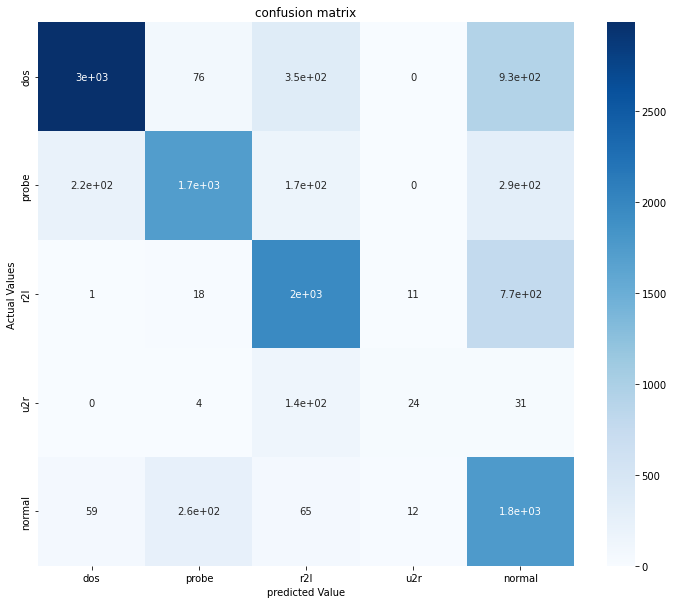

[0.68770152 0.71690258 0.70842411 0.12       0.81784387] [0.03729355 0.03746825 0.07992524 0.00197425 0.20859971]


In [ ]:
testPredict = model_2.predict(test21Input)
testPredict=(testPredict == testPredict.max(axis=1, keepdims=1)).astype(float)
cm=confusion_matrix(test21Output.values.argmax(axis=1),testPredict.argmax(axis=1))
#print(cm)
fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
FPR = fp/(fp+tn)
DR=tp/(tp+fn)
ACC = (tp+tn)/(tp+fp+fn+tn)
#cm_df=pd.DataFrame(cm,columns=['dos','probe','r2l','u2r','normal'])
plt.figure(figsize=(12,10))
ax=sns.heatmap(cm,annot=True,cmap='Blues')
ax.xaxis.set_ticklabels(['dos','probe','r2l','u2r','normal'])
ax.yaxis.set_ticklabels(['dos','probe','r2l','u2r','normal'])
plt.title('confusion matrix')
plt.ylabel('Actual Values')
plt.xlabel('predicted Value')
plt.show()
print(DR,FPR)
#print(classification_report(testOutput,testPredict,digits=3))


In [ ]:
print(predict_MLP_Classification(model_2,trainInput,trainOutput))
print(predict_MLP_Classification(model_2,testInput,testOutput))
print(predict_MLP_Classification(model_2,test21Input,test21Output))


985/985 [==============================] - 4s 4ms/step - loss: 0.1307 - accuracy: 0.9712
{'Cost Function': 0.13065804541110992, 'Accuracy': 97.1200168132782}
177/177 [==============================] - 1s 4ms/step - loss: 7.1318 - accuracy: 0.8050
{'Cost Function': 7.131762981414795, 'Accuracy': 80.50479292869568}
93/93 [==============================] - 0s 4ms/step - loss: 13.5519 - accuracy: 0.6332
{'Cost Function': 13.551944732666016, 'Accuracy': 63.31645846366882}


In [ ]:
model_1,historty_1=BI_CNN1D(trainInput,trainOutput,testInput,testOutput,classweights)

NameError: ignored

In [ ]:
pred=model_1.predict(testInput)
print(pred)

[[0.37857604]
 [0.37857604]
 [0.37857604]
 ...
 [0.37857604]
 [1.        ]
 [0.37857604]]


In [ ]:
def BI_Evalution_Metrics(model,testInput,testOutput):
    pred=model_1.predict(testInput)
    y_pred = (pred > 0.5)
    y_true=testOutput.reshape(testOutput.size,1)
    cf_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
    fp = cf_matrix.sum(axis=0) - np.diag(cf_matrix)  
    fn = cf_matrix.sum(axis=1) - np.diag(cf_matrix)
    tp = np.diag(cf_matrix)
    tn = cf_matrix.sum() - (fp + fn + tp)
    FPR = fp/(fp+tn)
    DR=tp/(tp+fn)
    ACC = (tp+tn)/(tp+fp+fn+tn)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    #ax.set_title('Confusion matrix obtained by testing KDDTest21 dataset for binary classification\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Anormal','normal'])
    ax.yaxis.set_ticklabels(['Anormal','normal'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    return ACC,DR,FPR

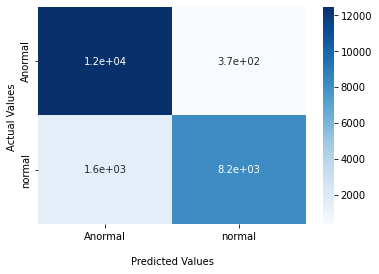

{'Accuracy': array([0.914434, 0.914434]), 'Detection Rate': array([0.97132393, 0.83925445]), 'False positive Rate': array([0.16074555, 0.02867607])}


In [ ]:
AC,DR,FPR=BI_Evalution_Metrics(model_1,testInput,testOutput)
print({"Accuracy" : AC,"Detection Rate" : DR,"False positive Rate" : FPR})

In [ ]:
print(predict_MLP_Classification(model_1,trainInput,trainOutput))
print(predict_MLP_Classification(model_1,testInput,testOutput))
print(predict_MLP_Classification(model_1,test21Input,test21Output))

985/985 [==============================] - 4s 4ms/step - loss: 0.3703 - accuracy: 0.8600
{'Cost Function': 0.37027260661125183, 'Accuracy': 86.00493669509888}
177/177 [==============================] - 1s 5ms/step - loss: 3.0984 - accuracy: 0.9144
{'Cost Function': 3.0983974933624268, 'Accuracy': 91.4434015750885}
93/93 [==============================] - 0s 5ms/step - loss: 5.7280 - accuracy: 0.8788
{'Cost Function': 5.727993011474609, 'Accuracy': 87.88185715675354}


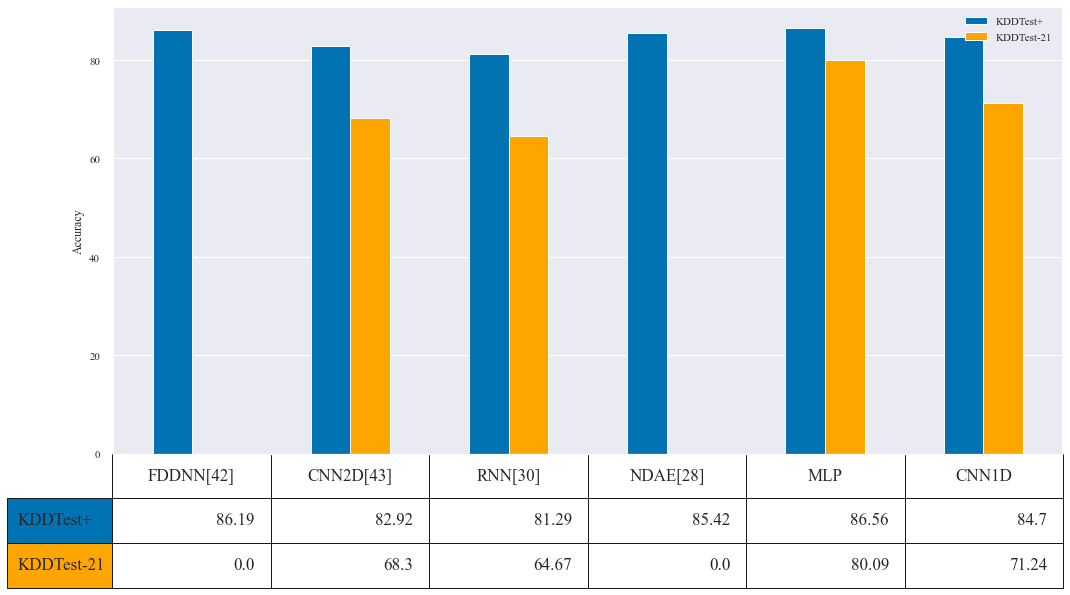

In [ ]:
df = pd.DataFrame([])
#df["KDDTest+"]=[69.52,80.67,81.67,89.59,91.4]
#df["KDDTest-21"]=[42.29,63.26,63.97,81.95,87.8]
df["KDDTest+"]=[86.19,82.92,81.29,85.42,86.56,84.7]
df["KDDTest-21"]=[0,68.30,64.67,0,80.09,71.24]
df["algorithm"]=['FDDNN[42]','CNN2D[43]','RNN[30]','NDAE[28]',"MLP","CNN1D"]

ax = df.plot.bar(x='algorithm', y=['KDDTest+','KDDTest-21'], figsize=(15, 9),color=["b","orange"])


plt.ylabel('Accuracy')

#remove all x-labels since the table will be used instead
plt.xlabel('')
plt.xticks([])

table_columns = df['algorithm'].values.tolist()
open = df['KDDTest+'].values.tolist()
closed = df['KDDTest-21'].values.tolist()
table_data = [open, closed]
table_rows = df.columns.values.tolist()[0:2]
the_table=plt.table(cellText=table_data, rowLabels=table_rows, colLabels=table_columns, loc='bottom',rowColours=["b","orange"])
the_table.auto_set_font_size(False)
the_table.set_fontsize(17)

plt.tight_layout()
plt.subplots_adjust(bottom=0.29)
cell_dict = the_table.get_celld()
for i in cell_dict:
    # print(i)
    cell_dict[i].set_height(0.10)
    cell_dict[i].set_width(0.167)
plt.savefig("myimage.png", dpi=1500)
plt.show()
plt.close()

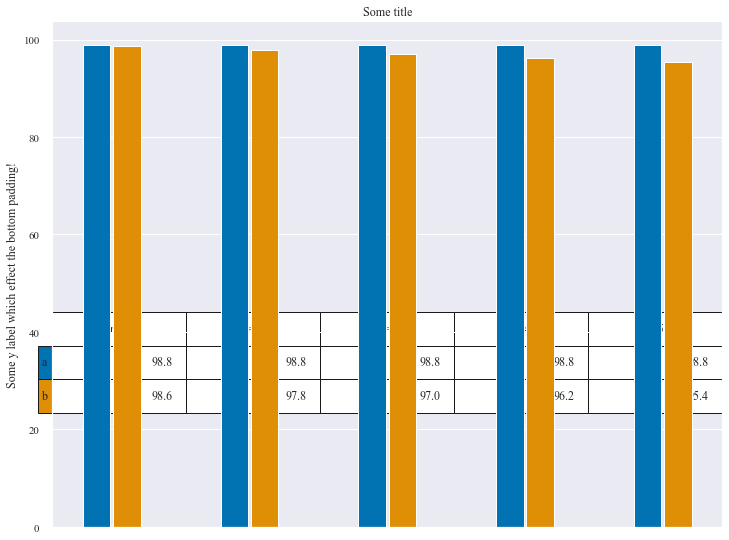

In [ ]:
plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.style.use(['seaborn'])
sns.set(palette='colorblind')
matplotlib.rc("font", family="Times New Roman", size=12)

labels = ['n=1','n=2','n=3','n=4','n=5']
a = [98.8,98.8,98.8,98.8,98.8]
b = [98.6,97.8,97.0,96.2,95.4]
bar_width = 0.20
data = [a,b]

colors = sns.color_palette(palette='colorblind')
columns = ('n=1', 'n=2', 'n=3', 'n=4', 'n=5')

index = np.arange(len(labels))
fig = plt.figure(figsize=(12,9))
plt.bar(index, a, bar_width)
plt.bar(index+bar_width+.02, b, bar_width)
plt.table(cellText=data,
          rowLabels=[' a ', ' b '],
          rowColours=colors,
          colLabels=columns,
          loc='bottom',
          bbox=[0, 0.225, 1, 0.2])

fig.subplots_adjust(bottom=0.1)

plt.ylabel('Some y label which effect the bottom padding!')
plt.xticks([])
plt.title('Some title')
plt.show()